<h1><center><font size="6">Pretrained Models Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>ResNet50</a>
    - <a href='#21'>Generating the Datasets</a> 
    - <a href='#22'>Constructing the Model</a> 
    - <a href='#23'>Compiling the Model</a>   
    - <a href='#23'>Defining Callbacks</a>
    - <a href='#24'>Training the Model</a>     
    - <a href='#25'>Evaluating the Model</a> 
    - <a href='#26'>Predicting on Holdout Set</a>
    - <a href='#27'>Confusion Matrix</a> 
- <a href='#3'>AlexNet</a> 
    - <a href='#31'>Generating the Datasets</a> 
    - <a href='#32'>Constructing and Compiling the Model</a> 
    - <a href='#33'>Defining Callbacks</a>
    - <a href='#34'>Training the Model</a>     
    - <a href='#35'>Evaluating the Model</a> 
    - <a href='#36'>Predicting on Holdout Set</a>
    - <a href='#37'>Confusion Matrix</a> 
    - <a href='#38'>Saving the Model</a>  
- <a href='#4'>VGG19</a>    
    - <a href='#41'>Generating the Datasets</a> 
    - <a href='#42'>Constructing and Compiling the Model</a> 
    - <a href='#43'>Defining Callbacks and Training the Model</a> 
    - <a href='#44'>Evaluating the Model</a> 
    - <a href='#45'>Predicting on Holdout Set</a>
    - <a href='#46'>Confusion Matrix</a> 
    - <a href='#47'>ROC-AUC and PR-AUC Curves</a>
    - <a href='#47'>Saving the Model</a>      


# <a id='1'>Importing Packages</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm
import datetime
import itertools 
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

%reload_ext autoreload
%autoreload 2
from utils import *

# <a id='2'>ResNet50 Architecture</a>



## <a id='21'>Generating the Datasets</a>

In [4]:
# Set path for training testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='22'>Constructing the Model</a>

In [2]:
# model creation
cnn_base = ResNet50(include_top = False,
                    weights = "imagenet",
                    input_shape = (224, 224, 3))

for layer in cnn_base.layers[:143]:
    layer.trainable = False
    
model = Sequential([
    cnn_base,
    Flatten(),
    BatchNormalization(),
    Dense(units = 256, activation = 'relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units = 128, activation = 'relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units = 1, activation = 'sigmoid')
])


## <a id='23'>Compiling the Model</a>

In [5]:
# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy', Precision(), Recall(), AUC(), AUC(curve='PR')])

## <a id='24'>Defining Callbacks</a>


In [7]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
# earlyStopping = EarlyStopping(monitor = 'val_loss', 
#                               verbose = 1, 
#                               mode = 'min', 
#                               patience = 4)
filepath = "../logs/log_resnet_2/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
log_dir = "../logs/log_resnet_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('../logs/log_resnet_2/log.csv')

## <a id='25'>Training the Model</a>


In [8]:
# train model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 20,
                             callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 2666s 6s/step - loss: 0.5415 - accuracy: 0.7376 - precision: 0.4897 - recall: 0.6132 - auc: 0.7607 - auc_1: 0.6127 - val_loss: 0.3199 - val_accuracy: 0.8830 - val_precision: 0.8889 - val_recall: 0.1569 - val_auc: 0.8556 - val_auc_1: 0.6028

Epoch 00001: saving model to ../logs/log_resnet_2/model.01-0.32.hdf5
Epoch 2/20
427/427 [==============================] - 2341s 5s/step - loss: 0.3226 - accuracy: 0.8780 - precision: 0.7808 - recall: 0.6653 - auc: 0.8910 - auc_1: 0.7885 - val_loss: 3.3024 - val_accuracy: 0.8644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4992 - val_auc_1: 0.1346

Epoch 00002: saving model to ../logs/log_resnet_2/model.02-3.30.hdf5
Epoch 3/20
427/427 [==============================] - 2383s 6s/step - loss: 0.3167 - accuracy: 0.8831 - precision: 0.8073 - recall: 0.6851 - auc: 0.8964 - auc_1: 0.8116 - val_loss: 0.6885 - val_accuracy: 0.5372 - val_precision: 0.2217 - val_recall: 0.9608 - val_au

## <a id='26'>Evaluating the Model</a>


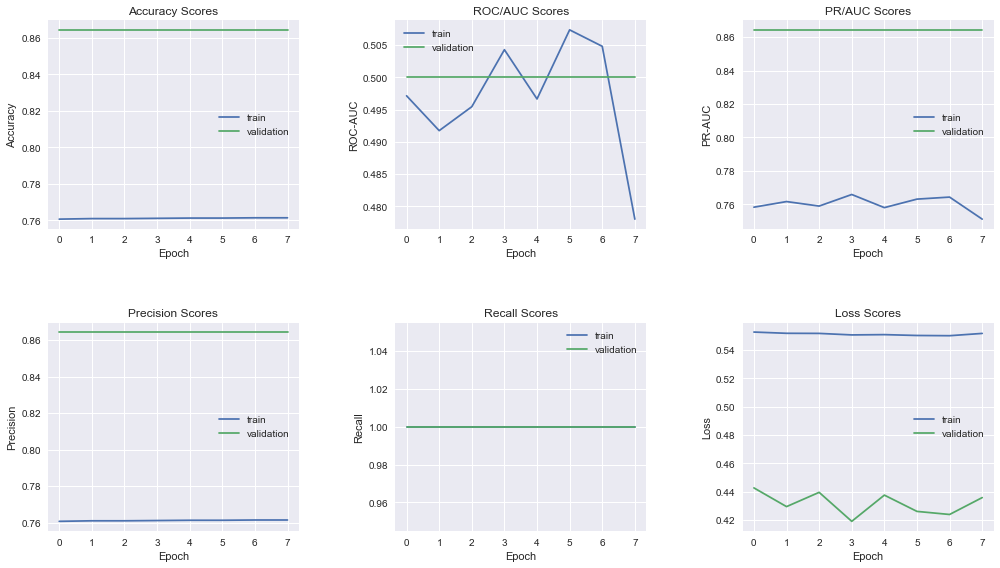

In [17]:
# visualization of the metrics tracked during training
plt.style.use('seaborn')
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [18]:
# display dataframe of the metrics per epoch
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1,lr
0,0.552730,0.760698,0.760698,1.0,0.497142,0.758316,0.442683,0.864362,0.864362,1.0,0.5,0.864362,0.00100
1,0.551858,0.760991,0.760991,1.0,0.491740,0.761676,0.429458,0.864362,0.864362,1.0,0.5,0.864362,0.00100
2,0.551781,0.760991,0.760991,1.0,0.495453,0.758982,0.439537,0.864362,0.864362,1.0,0.5,0.864362,0.00100
3,0.550714,0.761137,0.761137,1.0,0.504290,0.765905,0.419065,0.864362,0.864362,1.0,0.5,0.864362,0.00100
4,0.550916,0.761284,0.761284,1.0,0.496651,0.758056,0.437575,0.864362,0.864362,1.0,0.5,0.864362,0.00050
5,0.550318,0.761284,0.761284,1.0,0.507367,0.763140,0.426081,0.864362,0.864362,1.0,0.5,0.864362,0.00050
6,0.550156,0.761430,0.761430,1.0,0.504817,0.764352,0.423906,0.864362,0.864362,1.0,0.5,0.864362,0.00050
7,0.551772,0.761430,0.761430,1.0,0.478015,0.751172,0.435827,0.864362,0.864362,1.0,0.5,0.864362,0.00025


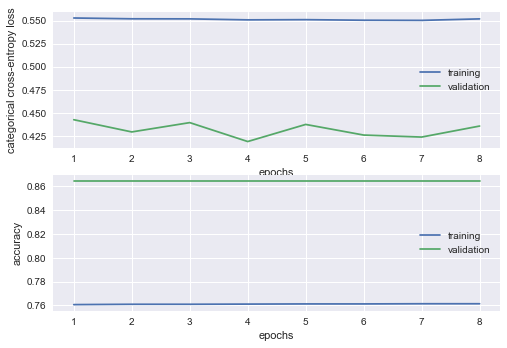

In [20]:
# visualize loss and accuracy
plt.style.use('seaborn')
train_val_metrics(8, history)

## Loading Best Model

## <a id='27'>Predicting on Holdout Set</a>

In [34]:
# get testing loss and accuracy
X_test, y_test = next(test_generator)
score = model.evaluate(X_test, y_test, verbose = 1)
labels = model.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1/1 [==============================] - 2s 2s/step - loss: 1.3920 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - auc_1: 0.0000e+00
loss: 1.392035961151123
accuracy: 0.0


## <a id='28'>Confusion Matrix</a>

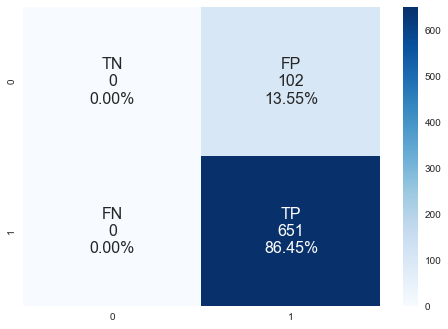

In [28]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

# <a id='3'>AlexNet Architecture</a>


## <a id='31'>Generating the Datasets</a>

In [2]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (227, 227),
        batch_size = 16,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (227, 227),
        batch_size = 16,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (227, 227),
        batch_size = 1,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='32'>Constructing and Compiling the Model</a>

In [6]:
# construct model
model2 = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile model
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', Precision(), Recall(), AUC(), AUC(curve='PR')])

## <a id='33'>Defining Callbacks</a>

In [7]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
filepath = "../logs/log_alexnet2/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
log_dir = "../logs/log_alexnet2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('../logs/log_alexnet2/log.csv')

## <a id='34'>Training the Model</a>

In [42]:
# train model
history2 = model2.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 4282s 10s/step - loss: 7.8137 - accuracy: 0.8608 - precision_1: 0.9090 - recall_1: 0.9079 - auc_2: 0.8322 - auc_3: 0.9125 - val_loss: 0.3881 - val_accuracy: 0.9109 - val_precision_1: 0.9206 - val_recall_1: 0.9815 - val_auc_2: 0.8884 - val_auc_3: 0.9698

Epoch 00001: saving model to ../logs/log_alexnet/weights-improvement-01-0.39.hdf5
Epoch 2/20
427/427 [==============================] - 4929s 12s/step - loss: 0.6389 - accuracy: 0.8910 - precision_1: 0.9236 - recall_1: 0.9339 - auc_2: 0.9120 - auc_3: 0.9557 - val_loss: 0.2953 - val_accuracy: 0.9136 - val_precision_1: 0.9137 - val_recall_1: 0.9938 - val_auc_2: 0.9072 - val_auc_3: 0.9765

Epoch 00002: saving model to ../logs/log_alexnet/weights-improvement-02-0.30.hdf5
Epoch 3/20
427/427 [==============================] - 4970s 12s/step - loss: 0.4187 - accuracy: 0.8980 - precision_1: 0.9234 - recall_1: 0.9443 - auc_2: 0.9277 - auc_3: 0.9657 - val_loss: 0.3824 - val_accuracy: 0.9362 - 

## <a id='35'>Evaluating the Model</a>

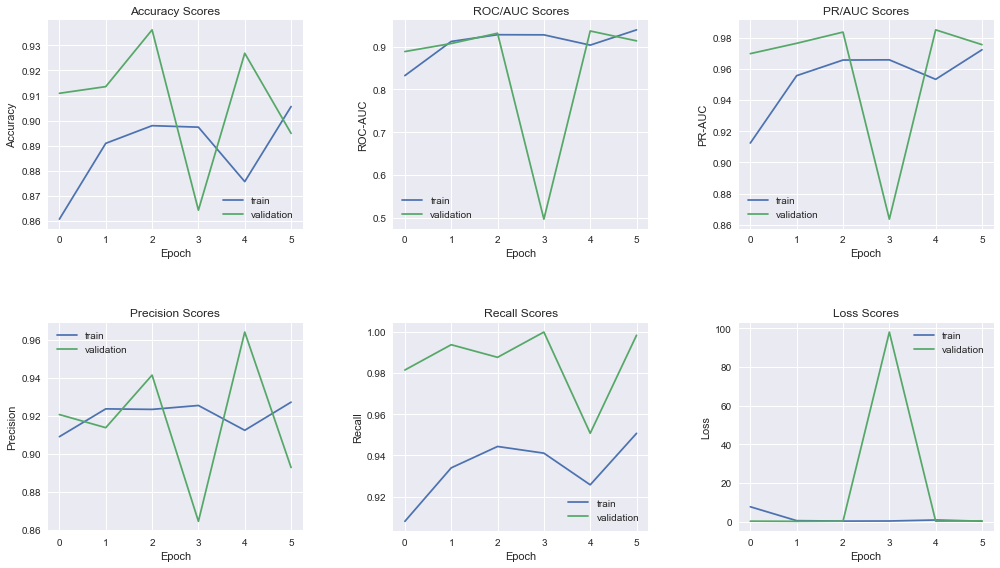

In [43]:
# visualize metrics measured
plt.style.use('seaborn')
sixplot(history2, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

In [44]:
# display dataframe of metriccs
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_1,recall_1,auc_2,auc_3,val_loss,val_accuracy,val_precision_1,val_recall_1,val_auc_2,val_auc_3,lr
0,7.813650,0.860785,0.908986,0.907935,0.832246,0.912480,0.388073,0.910904,0.920635,0.981538,0.888416,0.969848,0.001
1,0.638907,0.890973,0.923634,0.933950,0.912006,0.955711,0.295269,0.913564,0.913720,0.993846,0.907172,0.976474,0.001
2,0.418699,0.898007,0.923367,0.944348,0.927745,0.965739,0.382426,0.936170,0.941435,0.987711,0.931248,0.983664,0.001
3,0.464771,0.897421,0.925421,0.941097,0.927415,0.965859,98.079224,0.864362,0.864362,1.000000,0.496923,0.863639,0.001
4,0.985056,0.875733,0.912351,0.925698,0.903431,0.953363,0.383877,0.926862,0.964119,0.950769,0.936433,0.985103,0.001
5,0.366652,0.905627,0.927177,0.950731,0.939079,0.972340,0.544970,0.894947,0.892710,0.998462,0.913356,0.975612,0.001


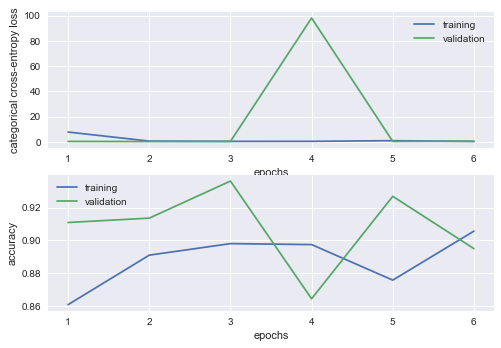

In [71]:
# display accuracy and loss for testing set
plt.style.use('seaborn')
train_val_metrics(6, history2)

## <a id='36'>Predicting on Holdout Set</a>

In [49]:
# get testing accuracy and loss
score = model2.evaluate_generator(test_generator, verbose = 1)

print(str("Loss: " + str(score[0]))
print(str("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))


753/753 [==============================] - 106s 141ms/step - loss: 0.9815 - accuracy: 0.9004 - precision_1: 0.8967 - recall_1: 1.0000 - auc_2: 0.8769 - auc_3: 0.9658
loss: 0.9815390706062317
accuracy: 0.9003984332084656


## <a id='37'>Confusion Matrix</a>

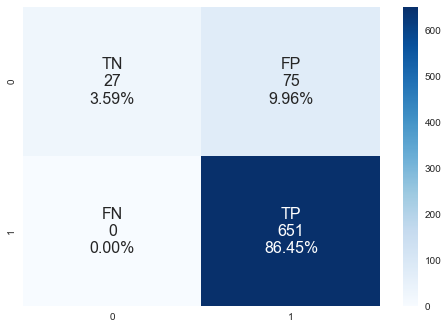

In [48]:
# create confusion matrix visualization
test_generator.reset()
y_pred = model2.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_2 = prob2 > 0.5
make_confusion_matrix(y_true, y_pred_2)

## <a id='38'>Saving the Model</a>

In [50]:
model2.save('../models/alexnet')

INFO:tensorflow:Assets written to: ../models/alexnet/assets


# <a id='4'>VGG19 Architecture</a>



## <a id='41'>Generating the Datasets</a>

In [2]:
# generate datasets
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        class_mode = 'binary',
        classes = ['0_not_mel', '1_mel'],
        batch_size = 1,
        seed = 42,
        shuffle = False)

STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='42'>Constructing and Compiling the Model</a>

In [3]:
# construct model
vgg_19 = VGG19(include_top = False, 
               weights = 'imagenet', 
               input_shape = (224, 224, 3))

vgg_19.trainable = False

model3 = Sequential([
    vgg_19,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile model
model3.compile(optimizer = Adam(lr = 0.001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

## <a id='43'>Defining Callbacks and Training the Model</a>

In [4]:
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_vgg19_2/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_vgg19_2/log.csv')
log_dir = "../logs/log_vgg19_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

In [ ]:
# train model
history3 = model3.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

## <a id='44'>Evaluating the Model</a>

In [9]:
history3 = pd.read_csv('../logs/log_vgg19_2/log.csv')
history3

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.925585,0.930448,0.893892,0.340852,0.00100,0.896965,0.777846,0.941333,0.949460,0.844735,0.193389,0.784314,0.784314
1,1,0.949854,0.971580,0.951711,0.146171,0.00100,0.939415,0.844553,0.949333,0.954748,0.868598,0.155882,0.880952,0.725490
2,2,0.958041,0.980300,0.965955,0.120368,0.00100,0.949900,0.870257,0.953333,0.971106,0.897320,0.129261,0.883721,0.752475
3,3,0.960526,0.981926,0.967256,0.115458,0.00100,0.951058,0.880049,0.954667,0.966216,0.903623,0.128643,0.869565,0.784314
4,4,0.964766,0.987008,0.974258,0.102543,0.00100,0.954338,0.895349,0.934667,0.955678,0.891548,0.163687,0.964912,0.539216
5,5,0.965936,0.984313,0.972716,0.104038,0.00100,0.960552,0.894125,0.958667,0.963615,0.900265,0.139499,0.906977,0.772277
6,6,0.970322,0.986005,0.976174,0.099891,0.00100,0.963707,0.910037,0.908000,0.808112,0.719094,0.554893,1.000000,0.323529
7,7,0.973538,0.988892,0.979189,0.083327,0.00100,0.971447,0.916157,0.957333,0.958295,0.907975,0.143331,0.948718,0.725490
8,8,0.975439,0.991720,0.984593,0.073873,0.00100,0.969872,0.925949,0.954667,0.958848,0.907075,0.160766,0.914634,0.735294
9,9,0.983626,0.994637,0.990102,0.052462,0.00050,0.984097,0.946756,0.961333,0.963028,0.909910,0.140015,0.860000,0.851485


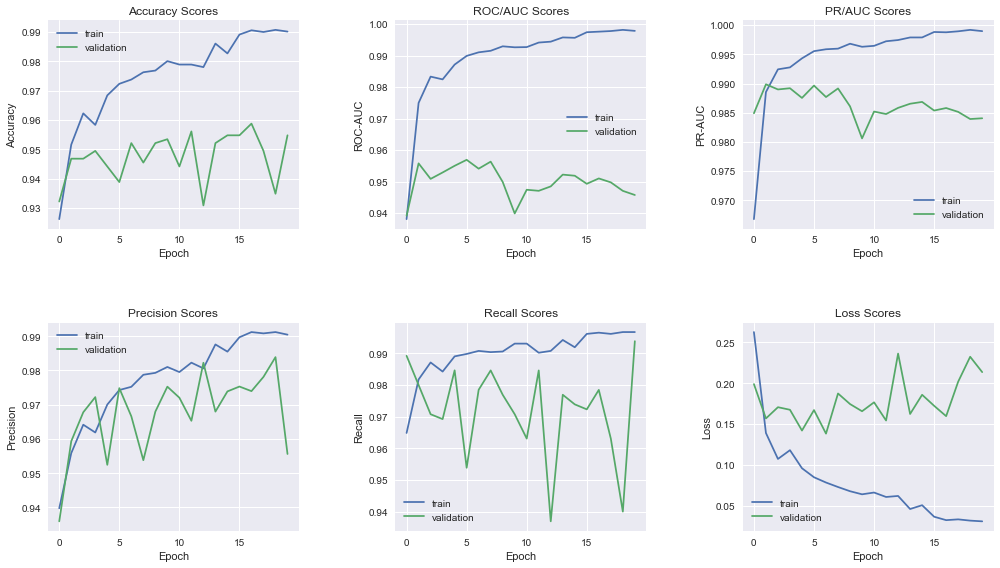

In [60]:
# evaluate model 

plt.style.use('seaborn')
sixplot2(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [61]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3,lr
0,0.262785,0.926170,0.938105,0.966774,0.939757,0.964848,0.199009,0.932181,0.939201,0.984906,0.935953,0.989231,0.0010
1,0.139081,0.951608,0.975001,0.988541,0.955863,0.981752,0.156916,0.946809,0.955807,0.989868,0.959337,0.980000,0.0010
2,0.107300,0.962281,0.983352,0.992432,0.964165,0.987130,0.170709,0.946809,0.950882,0.988987,0.967791,0.970769,0.0010
3,0.118029,0.958333,0.982473,0.992768,0.961892,0.984249,0.167556,0.949468,0.952919,0.989195,0.972222,0.969231,0.0010
4,0.095900,0.968421,0.987176,0.994314,0.970045,0.989051,0.142086,0.944149,0.955035,0.987535,0.952452,0.984639,0.0010
5,0.084858,0.972368,0.989928,0.995546,0.974286,0.989819,0.167189,0.938830,0.956938,0.989651,0.974843,0.953846,0.0010
6,0.078395,0.973830,0.991065,0.995871,0.975232,0.990780,0.138321,0.952128,0.954122,0.987688,0.966616,0.978495,0.0010
7,0.072894,0.976316,0.991553,0.995977,0.978740,0.990396,0.187529,0.945479,0.956357,0.989160,0.953800,0.984615,0.0010
8,0.067746,0.976901,0.992972,0.996820,0.979301,0.990588,0.174568,0.952128,0.949917,0.986094,0.967988,0.976923,0.0010
9,0.063952,0.980117,0.992658,0.996297,0.981025,0.993085,0.165739,0.953457,0.939910,0.980603,0.975270,0.970769,0.0010


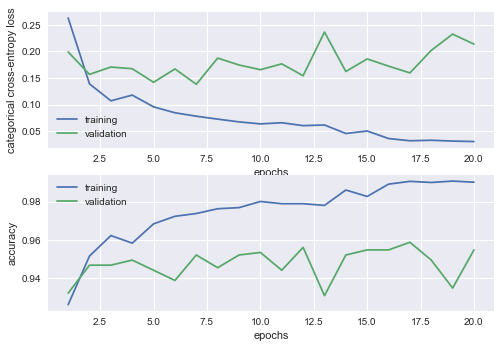

In [62]:
plt.style.use('seaborn')
train_val_metrics(20, history3)

In [ ]:
model_3 = load_model('../logs/log_cnn1a/model.16-0.15.hdf5')

## <a id='45'>Predicting on Test Set</a>

In [65]:
test_generator.reset()
score = model3.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))


753/753 [==============================] - 720s 957ms/step - loss: 0.2187 - accuracy: 0.9668 - auc_6: 0.9243 - auc_7: 0.9771 - precision_3: 0.9644 - recall_3: 0.9985
Loss: 0.21871446073055267
Accuracy: 0.9667994976043701
Precision: 0.9242868423461914
Recall: 0.9771350026130676
ROC-AUC: 0.9643917083740234
PR-AUC: 0.9984639286994934


## <a id='46'>Confusion Matrix</a>

753/753 [==============================] - 665s 884ms/step


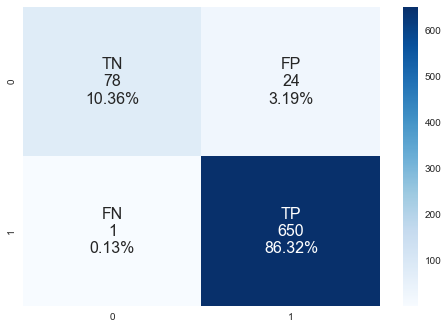

In [68]:
test_generator.reset()
prob3 = model3.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred_3)

## <a id='47'>ROC-AUC and PR-AUC Curves</a>

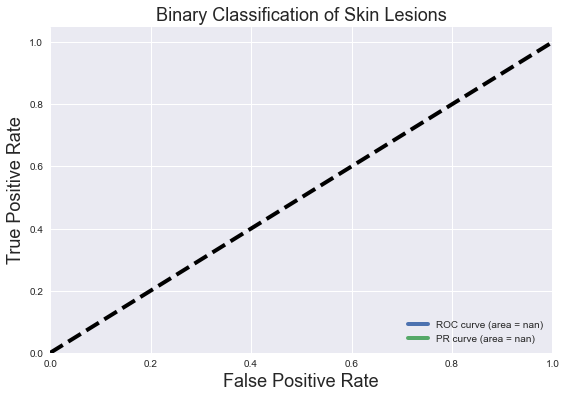

In [70]:
X_test, y_test = next(test_generator)
y_score = model3.predict_proba(X_test)
fpr, tpr, __ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
prec,rec, __ = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)

plt.figure(figsize = [9, 6])
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot(rec, prec, label = 'PR curve (area = %0.2f)' % pr_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Binary Classification of Skin Lesions', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()

## <a id='48'>Saving the Model</a>

In [67]:
model3.save('../models/vgg19')


INFO:tensorflow:Assets written to: ../models/vgg19/assets
